## **Framework  deep learning network polyps segmentation**

In [1]:
#Import the necessary libraries:
get_ipython().run_line_magic('env', 'SM_FRAMEWORK=tf.keras')
import random
import cv2
import os
import numpy as np
from numpy import zeros
from numpy.random import randint
import pandas as pd
from tqdm.notebook import tqdm, trange 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import decode_predictions, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Dense, Input, Add,  Activation,add,LayerNormalization,Layer
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization,Concatenate,SeparableConv2D
from tensorflow.keras.layers import Reshape, Conv2DTranspose, Dropout, Multiply,Conv2DTranspose,MaxPool2D
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, concatenate, UpSampling3D
from tensorflow.keras.layers import UpSampling2D,BatchNormalization,Dropout
from tensorflow.keras.layers import Input, Conv3D, Conv3DTranspose, MaxPooling3D, Conv2DTranspose
from keras.applications.vgg16 import VGG16
from keras.applications.densenet import DenseNet201, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import  Callback,ReduceLROnPlateau, ModelCheckpoint
from keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import MeanIoU

import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

import warnings

K.clear_session()
warnings.filterwarnings("ignore")

env: SM_FRAMEWORK=tf.keras


2023-05-22 21:11:10.265952: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-22 21:11:11.715000: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-22 21:11:11.716622: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 21:11:14.865952: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Segmentation Models: using `tf.keras` framework.


## **Importing and preprocessing dataset**

In [2]:
#Load Data and Display

H,W,CH=[128,128,3]
image_dir = 'Kvasir/train/images/'
mask_dir = 'Kvasir/train/masks/'


In [3]:
#Loading------------------------------
Images = []
for file in tqdm(sorted(os.listdir(image_dir))):
    if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
        image = tf.keras.preprocessing.image.load_img(image_dir + file, target_size=(H,W))
        image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255.
        Images.append(image)

Images = np.array(Images)

Masks = []
for file in tqdm(sorted(os.listdir(mask_dir))):
    if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
        image = tf.keras.preprocessing.image.load_img(mask_dir +  file, target_size=(H,W), color_mode='grayscale')
        image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255.
        Masks.append(image)

Masks = np.array(Masks)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [4]:
# Split the dataset into training and validation sets
x = Images
y = Masks
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print("x_train shape:",x_train.shape)
print("y_test shape:",x_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

x_train shape: (800, 128, 128, 3)
y_test shape: (200, 128, 128, 3)
y_train shape: (800, 128, 128, 1)
y_test shape: (200, 128, 128, 1)


## **Plot some of SAR images**

  0%|          | 0/9 [00:00<?, ?it/s]

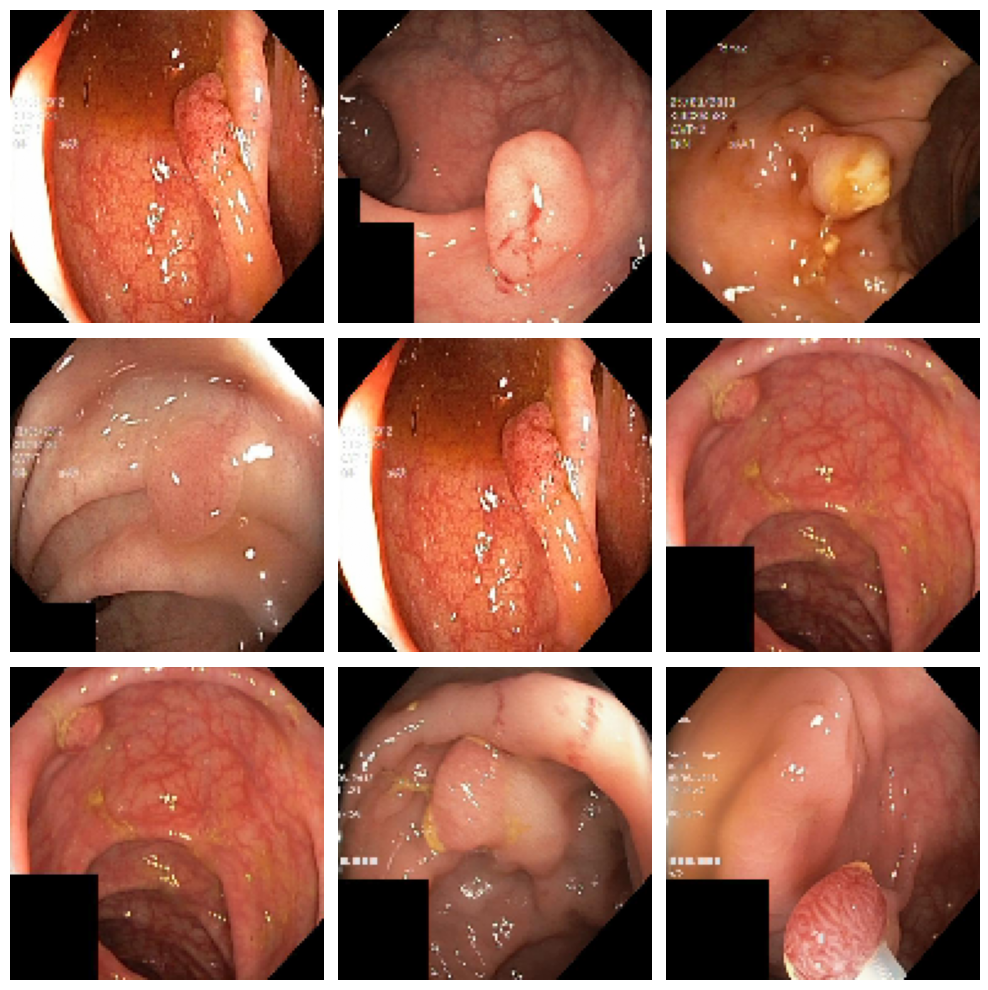

In [5]:
#Display---------------------
figure, axes = plt.subplots(8,2, figsize=(10,10))
indexes=[]
for i in tqdm(range(9)):
    index=random.randint(0,10)    
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[index],cmap='gray')
    plt.axis("off")

plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()


  0%|          | 0/9 [00:00<?, ?it/s]

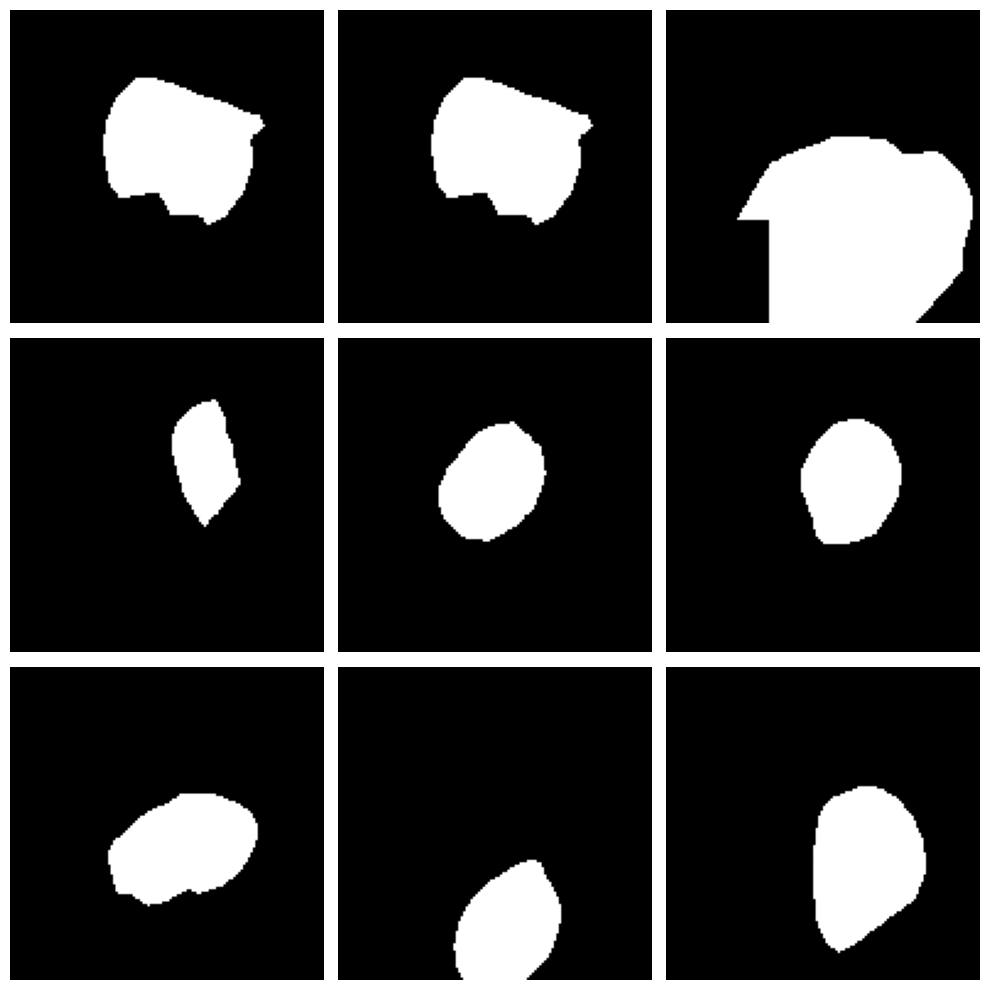

In [6]:
#Display---------------------
figure, axes = plt.subplots(8,2, figsize=(10,10))
indexes=[]
for i in tqdm(range(9)):
    index=random.randint(0,10)    
    plt.subplot(3,3,i+1)
    plt.imshow(y_train[index],cmap='gray')
    plt.axis("off")

plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()


  0%|          | 0/4 [00:00<?, ?it/s]

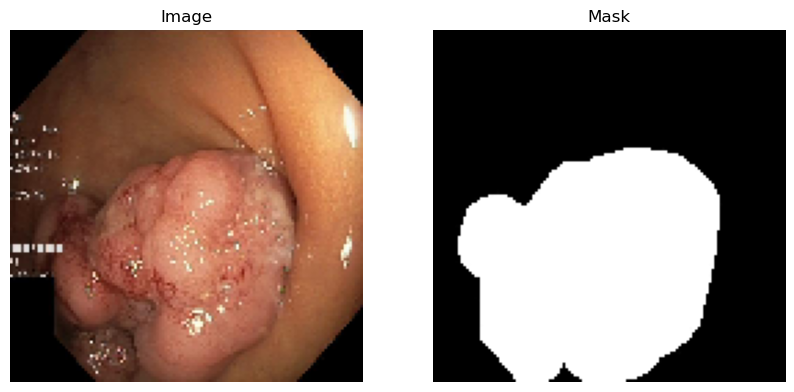

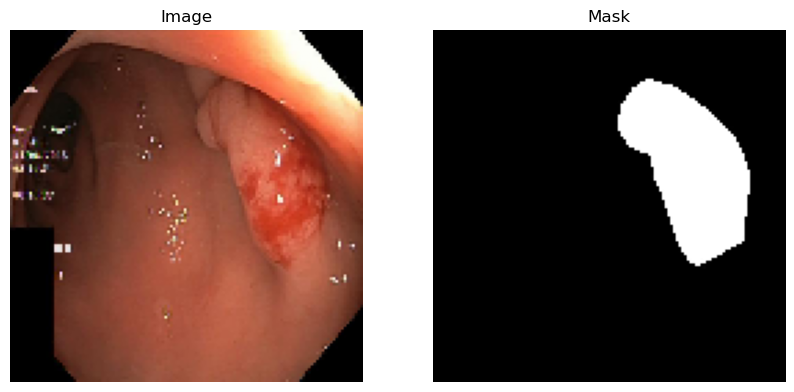

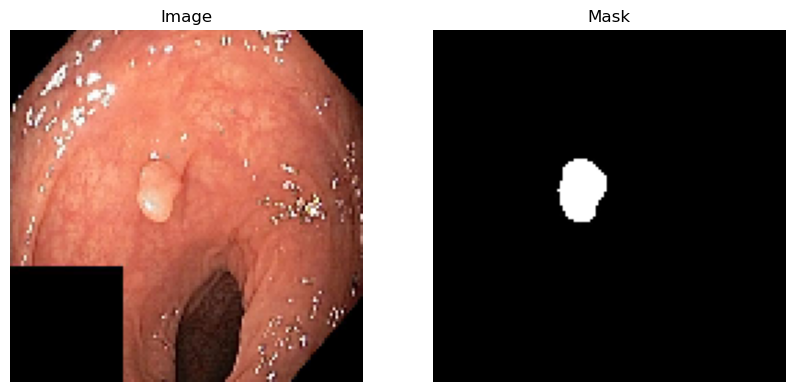

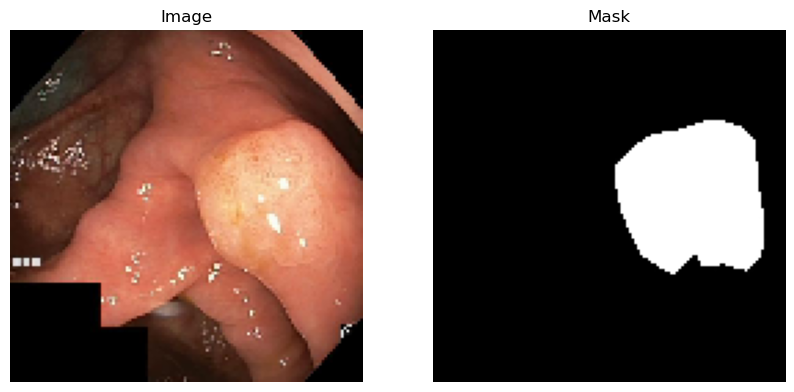

In [7]:
#Display test data
for i in tqdm(range(4)):
    idx = np.random.randint(0,80)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('Image', color = 'black', fontsize = 12)
    plt.imshow(x_train[idx],cmap='gray')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('Mask', color = 'black', fontsize = 12)
    plt.imshow(y_train[idx],cmap='gray')
    plt.axis('off')


## **Building CNN model architecture**

In [8]:
class Encoder(Layer):
    
    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        
        self.filters = filters
        self.rate = rate
        self.pooling = pooling
        
        self.bn = BatchNormalization()
        self.c1 = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer="he_normal")
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer="he_normal")
        self.pool = MaxPool2D()
        
    def call(self, X):
        x = self.bn(X)
        x = self.c1(x)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x
            
    def get_config(self):
        base_config = super().get_config()
        return {**base_config,"filters":self.filters,"rate":self.rate,"pooling":self.pooling}



In [9]:
class Decoder(Layer):
    
    def __init__(self, filters, rate, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        
        self.filters = filters
        self.rate = rate
        
        self.bn = BatchNormalization()
        self.cT = Conv2DTranspose(filters, kernel_size=3, strides=2, padding='same', activation='relu',
                                  kernel_initializer="he_normal")
        self.net = Encoder(filters, rate, pooling=False)
        
    def call(self, X):
        x, skip_x = X
        x = self.bn(x)
        x = self.cT(x)
        x = concatenate([x, skip_x])
        x = self.net(x)
        return x
            
    def get_config(self):
        base_config = super().get_config()
        return {**base_config,"filters":self.filters,"rate":self.rate,}
    


In [10]:
# Inputs
unet_inputs = Input(shape=(H,W,CH), name="UNetInput")

# Encoder Network : Downsampling phase
p1, c1 = Encoder(64, 0.1, name="Encoder1")(unet_inputs)
p2, c2 = Encoder(128, 0.1, name="Encoder2")(p1)
p3, c3 = Encoder(256, 0.2, name="Encoder3")(p2)
p4, c4 = Encoder(512, 0.2, name="Encoder4")(p3)

# Encoding Layer : Latent Representation
e = Encoder(512, 0.3, pooling=False)(p4)

# Attention + Decoder Network : Upsampling phase.
d1 = Decoder(512, 0.2, name="Decoder1")([e, c4])
d2 = Decoder(256, 0.2, name="Decoder2")([d1, c3])
d3 = Decoder(128, 0.1, name="Decoder3")([d2, c2])
d4 = Decoder(64, 0.1, name="Decoder4")([d3, c1])

# Output
unet_out = Conv2D(1, kernel_size=3, padding='same', activation='sigmoid')(d4)

# **Create model**

In [11]:
#Parameters
model = Model(inputs=unet_inputs,outputs=unet_out,name="AttentionUNet")

## **Loss functions**

In [12]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

## **Metrics**

In [14]:
#iou metric
smooth =100
def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

#jacard_coef
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

## **Model compilation**

In [15]:
#Model compile-------
model.compile( optimizer='adam',loss=[bce_jaccard_loss,dice_loss,'binary_crossentropy'],metrics=['accuracy', jacard_coef, iou]) 
#'sparse_categorical_crossentropy'=class>2
#'binary_crossentropy' class=2
model.summary()

Model: "AttentionUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 UNetInput (InputLayer)         [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Encoder1 (Encoder)             ((None, 64, 64, 64)  38732       ['UNetInput[0][0]']              
                                , (None, 128, 128,                                                
                                64))                                                              
                                                                                                  
 Encoder2 (Encoder)             ((None, 32, 32, 128  221696      ['Encoder1[0][0]']   

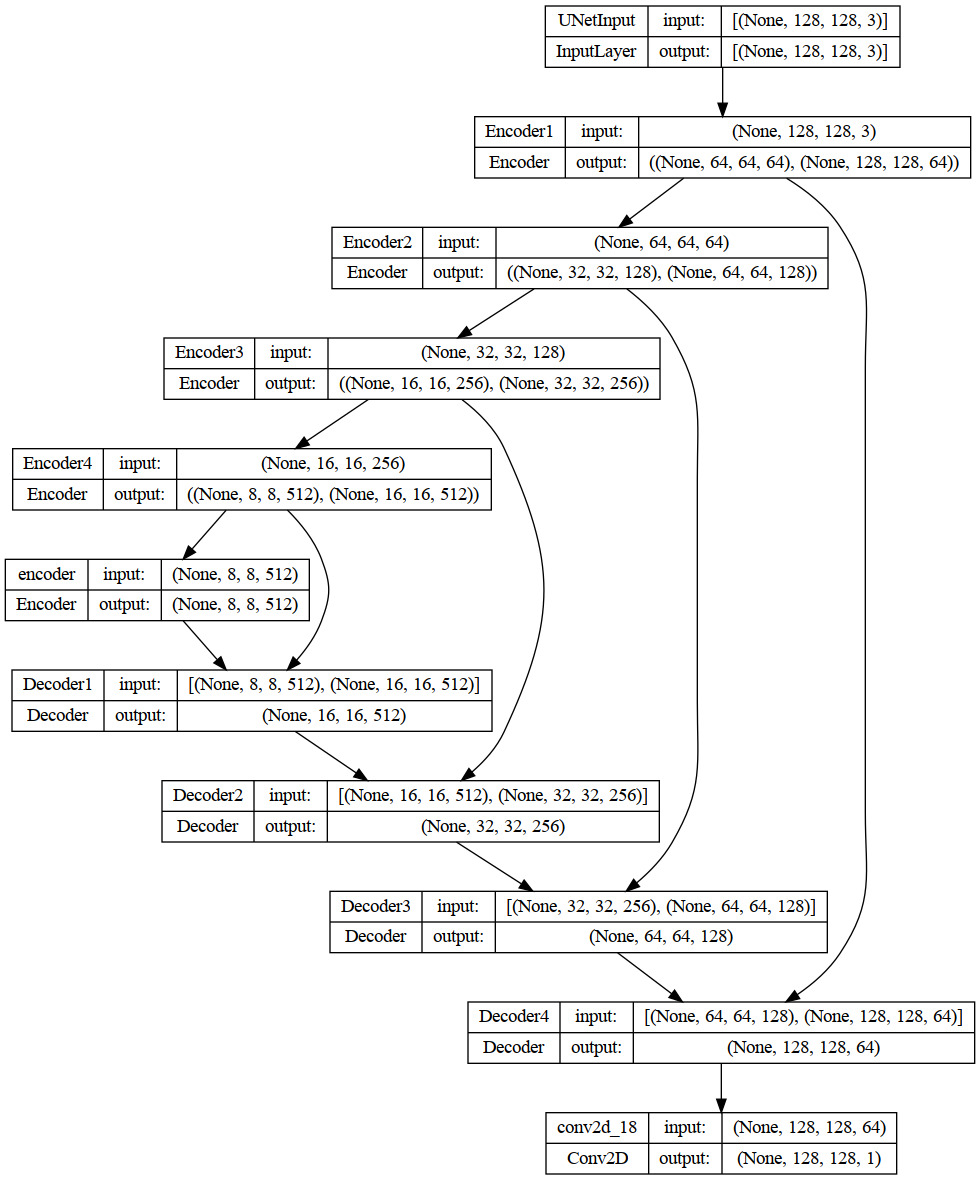

In [16]:
tf.keras.utils.plot_model(model, 'Model.png', show_shapes=True)


In [17]:
def show_image(image, title=None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

class ShowProgress(Callback):
    def on_epoch_end(self, epoch, logs=None):
        id = randint(len(x_test))
        image = x_test[id]
        mask = y_test[id]
        pred_mask = self.model(tf.expand_dims(image,axis=0))[0]
        
        plt.figure(figsize=(10,8))
        plt.subplot(1,3,1)
        show_image(image, title="Original Image")
        
        plt.subplot(1,3,2)
        show_image(mask, title="Original Mask")
        
        plt.subplot(1,3,3)
        show_image(pred_mask, title="Predicted Mask")
            
        plt.tight_layout()
        plt.show()

## **Model Training**

Epoch 1/25
16/16 [==============================] - ETA: 0s - loss: 1.2800 - accuracy: 0.7777 - jacard_coef: 0.1880 - iou: 0.1884 

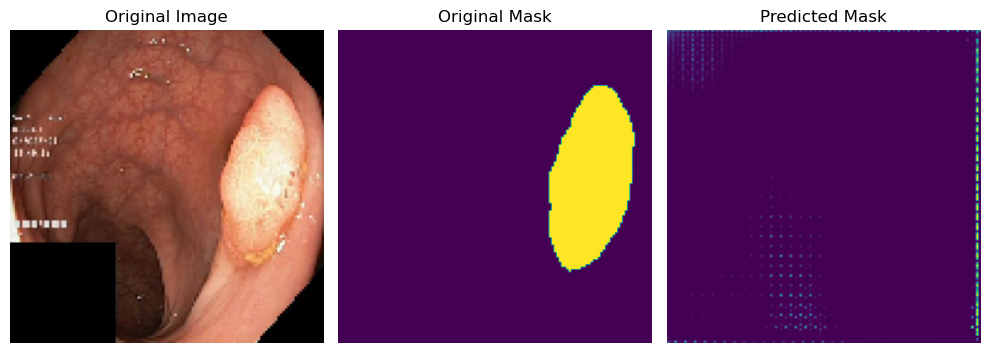

16/16 [==============================] - 651s 41s/step - loss: 1.2800 - accuracy: 0.7777 - jacard_coef: 0.1880 - iou: 0.1884 - val_loss: 7.1266 - val_accuracy: 0.8276 - val_jacard_coef: 0.0015 - val_iou: 0.0028
Epoch 2/25
16/16 [==============================] - ETA: 0s - loss: 1.0883 - accuracy: 0.8389 - jacard_coef: 0.2697 - iou: 0.2700 

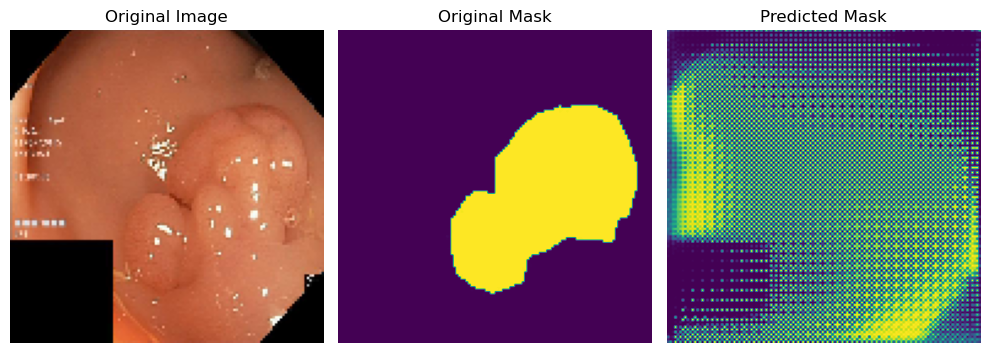

16/16 [==============================] - 650s 42s/step - loss: 1.0883 - accuracy: 0.8389 - jacard_coef: 0.2697 - iou: 0.2700 - val_loss: 4.7201 - val_accuracy: 0.5833 - val_jacard_coef: 0.1602 - val_iou: 0.1606
Epoch 3/25
16/16 [==============================] - ETA: 0s - loss: 1.0078 - accuracy: 0.8605 - jacard_coef: 0.3159 - iou: 0.3162 

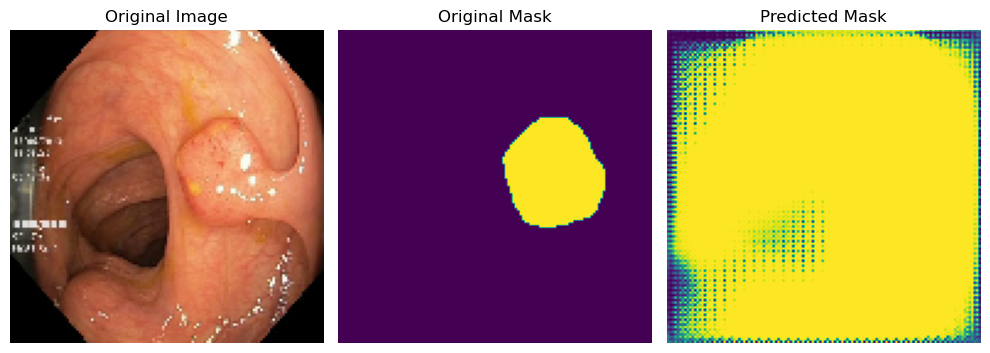

16/16 [==============================] - 617s 39s/step - loss: 1.0078 - accuracy: 0.8605 - jacard_coef: 0.3159 - iou: 0.3162 - val_loss: 14.6056 - val_accuracy: 0.2443 - val_jacard_coef: 0.1818 - val_iou: 0.1821
Epoch 4/25
16/16 [==============================] - ETA: 0s - loss: 0.9413 - accuracy: 0.8741 - jacard_coef: 0.3641 - iou: 0.3645 

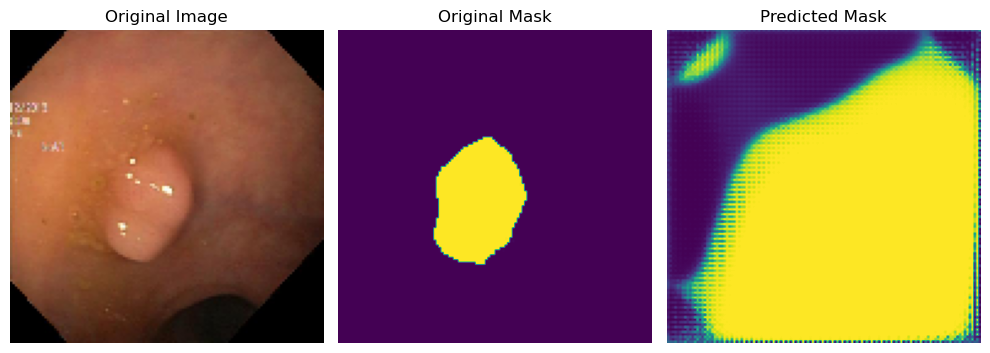

16/16 [==============================] - 613s 38s/step - loss: 0.9413 - accuracy: 0.8741 - jacard_coef: 0.3641 - iou: 0.3645 - val_loss: 12.0585 - val_accuracy: 0.3780 - val_jacard_coef: 0.1993 - val_iou: 0.1995
Epoch 5/25
16/16 [==============================] - ETA: 0s - loss: 0.9164 - accuracy: 0.8779 - jacard_coef: 0.3859 - iou: 0.3862 

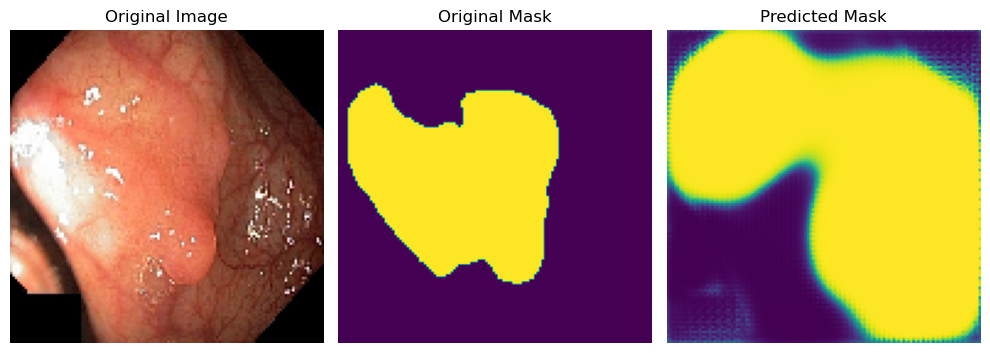

16/16 [==============================] - 622s 39s/step - loss: 0.9164 - accuracy: 0.8779 - jacard_coef: 0.3859 - iou: 0.3862 - val_loss: 10.1561 - val_accuracy: 0.4543 - val_jacard_coef: 0.2034 - val_iou: 0.2037
Epoch 6/25
16/16 [==============================] - ETA: 0s - loss: 0.8524 - accuracy: 0.8911 - jacard_coef: 0.4169 - iou: 0.4172 

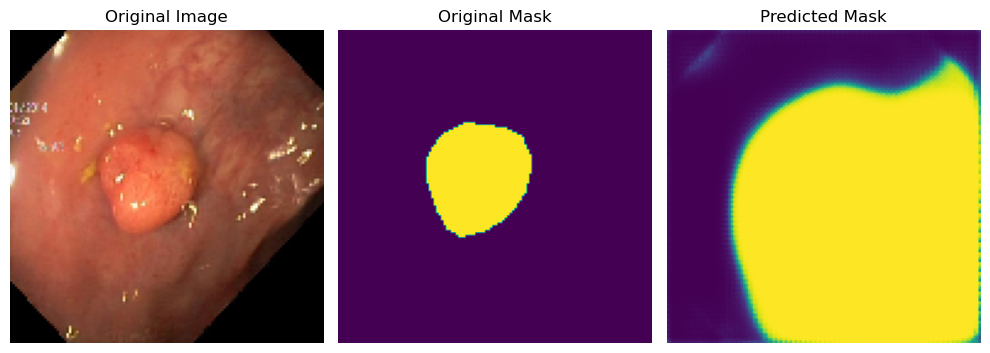

16/16 [==============================] - 594s 37s/step - loss: 0.8524 - accuracy: 0.8911 - jacard_coef: 0.4169 - iou: 0.4172 - val_loss: 12.6161 - val_accuracy: 0.4006 - val_jacard_coef: 0.2130 - val_iou: 0.2133
Epoch 7/25
16/16 [==============================] - ETA: 0s - loss: 0.8458 - accuracy: 0.8894 - jacard_coef: 0.4281 - iou: 0.4285 

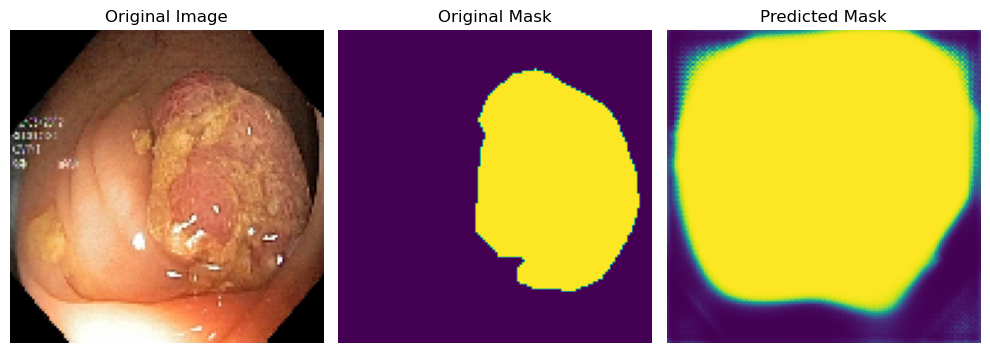

16/16 [==============================] - 658s 42s/step - loss: 0.8458 - accuracy: 0.8894 - jacard_coef: 0.4281 - iou: 0.4285 - val_loss: 16.0560 - val_accuracy: 0.3290 - val_jacard_coef: 0.1963 - val_iou: 0.1966
Epoch 8/25
16/16 [==============================] - ETA: 0s - loss: 0.7792 - accuracy: 0.9054 - jacard_coef: 0.4766 - iou: 0.4770 

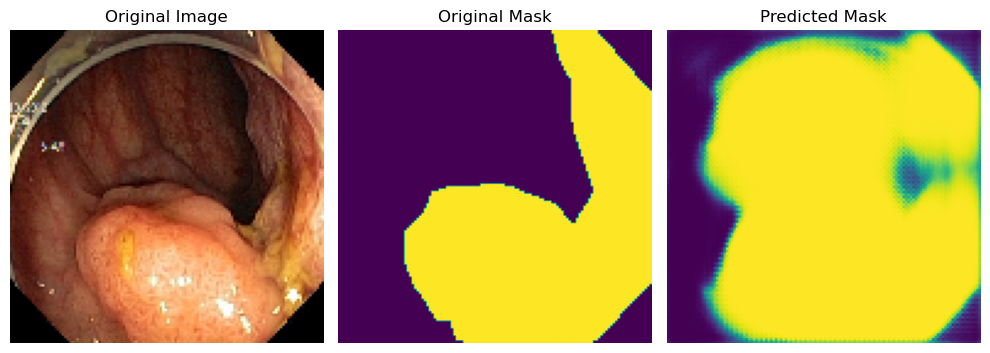

16/16 [==============================] - 600s 38s/step - loss: 0.7792 - accuracy: 0.9054 - jacard_coef: 0.4766 - iou: 0.4770 - val_loss: 4.4144 - val_accuracy: 0.4877 - val_jacard_coef: 0.2404 - val_iou: 0.2407
Epoch 9/25
16/16 [==============================] - ETA: 0s - loss: 0.7239 - accuracy: 0.9134 - jacard_coef: 0.5105 - iou: 0.5108 

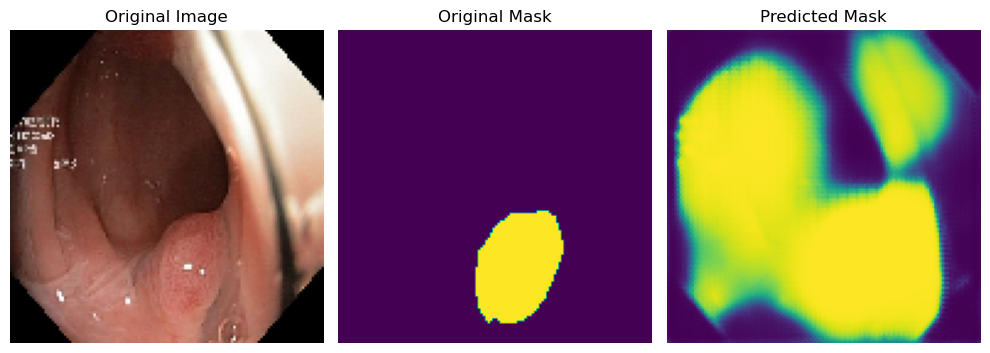

16/16 [==============================] - 595s 37s/step - loss: 0.7239 - accuracy: 0.9134 - jacard_coef: 0.5105 - iou: 0.5108 - val_loss: 4.0140 - val_accuracy: 0.4699 - val_jacard_coef: 0.2350 - val_iou: 0.2353
Epoch 10/25
16/16 [==============================] - ETA: 0s - loss: 0.6574 - accuracy: 0.9222 - jacard_coef: 0.5557 - iou: 0.5560 

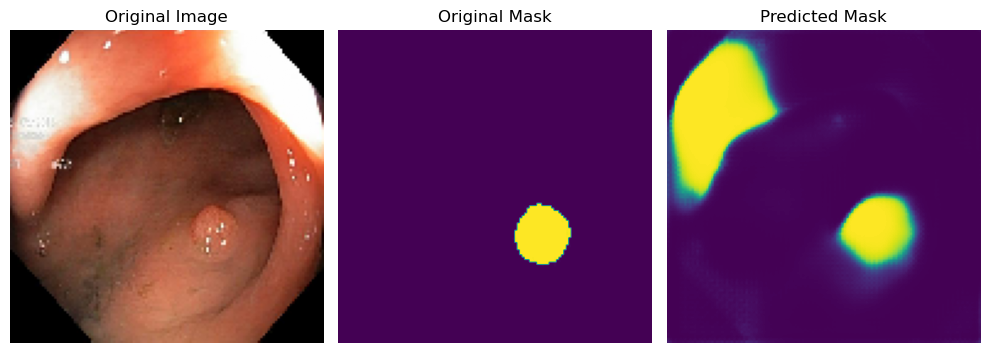

16/16 [==============================] - 603s 38s/step - loss: 0.6574 - accuracy: 0.9222 - jacard_coef: 0.5557 - iou: 0.5560 - val_loss: 1.5691 - val_accuracy: 0.7837 - val_jacard_coef: 0.3149 - val_iou: 0.3153
Epoch 11/25
15/16 [===========================>..] - ETA: 35s - loss: 0.6437 - accuracy: 0.9246 - jacard_coef: 0.5726 - iou: 0.5729 

In [ ]:
#Model Training
nepochs=25
nbatch_size=48
SPE = len(x_train)//nbatch_size
cbs = [ShowProgress()]

history = model.fit(x_train, y_train, epochs=nepochs, validation_data=(x_test, y_test),
                    batch_size=nbatch_size,steps_per_epoch=SPE,verbose=1,callbacks=cbs,shuffle=True,
                    max_queue_size=8,workers=1,use_multiprocessing=True,
                   )

In [ ]:
df_result = pd.DataFrame(history.history)
df_result

## **Performance evaluation**

In [ ]:
# Plotting loss change over epochs---------------
nrange=nepochs
x = [i for i in range(nrange)]
plt.plot(x,history.history['loss'])
plt.title('change in loss over epochs')
plt.legend(['training_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
plt.tight_layout()

# Plotting accuracy change over epochs---------------------
x = [i for i in range(nrange)]
plt.plot(x,history.history['accuracy'])
plt.title('change in training accuracy coefitient over epochs')
plt.legend(['training accuracy'])
plt.xlabel('epochs')
plt.ylabel('training accuracy')
plt.show()
plt.tight_layout()

# Plotting jacard  accuracy change over epochs---------------------
x = [i for i in range(nrange)]
plt.plot(x,history.history['jacard_coef'])
plt.title('change in jacard_coef coefitient over epochs')
plt.legend(['jacard_coef'])
plt.xlabel('epochs')
plt.ylabel('jacard_coef')
plt.show()
plt.tight_layout()

# Plotting iou accuracy change over epochs---------------------
x = [i for i in range(nrange)]
plt.plot(x,history.history['iou'])
plt.title('change in iou coefitient over epochs')
plt.legend(['iou'])
plt.xlabel('epochs')
plt.ylabel('iou')
plt.show()
plt.tight_layout()


## **Model Evaluation**

In [ ]:
# predict test images
predict_y = model.predict(x_test)

plt.figure(figsize=(15,15))
for i in range(0,9,3):
    plt.subplot(4,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i])
    plt.title('High image')
    
    plt.subplot(4,3,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[i])
    plt.title('Low image')
    
    plt.subplot(4,3,i+3)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(predict_y[i])
    plt.title('Output by model')

plt.show()

## **Model predictions**

In [ ]:
# Creating predictions on our test set-----------------
predictions = model.predict(x_test)

In [ ]:
# create predictes mask--------------
def create_mask(predictions,input_shape=(W,H,1)):
    mask = np.zeros(input_shape)
    mask[predictions>0.5] = 1
    return mask


In [ ]:
# Ploting results for one image----------------

def plot_results_for_one_sample(sample_index):    
    mask =predictions[sample_index] #create_mask(predictions[sample_index])   for gray-scale
    fig = plt.figure(figsize=(20,20))
    #image-------------------
    fig.add_subplot(1,4,1)
    plt.title('Input image')
    plt.imshow(x_test[sample_index])
    plt.axis('off')
    plt.grid(None)
    #mask-----------
    fig.add_subplot(1,4,2)
    plt.title('Real mask')
    plt.imshow(y_test[sample_index],cmap='gray')
    plt.axis('off')
    plt.grid(None)
    #Predicted mask------------
    fig.add_subplot(1,4,3)
    plt.title('Predicted mask')  
    plt.imshow(mask,cmap='gray')
    plt.axis('off')
    plt.grid(None)
    #Segment---------------
    fig.add_subplot(1,4,4)
    plt.title("Segment image")
    plt.imshow(x_test[sample_index]*mask)
    plt.grid(None)
    plt.axis('off')  
    fig.tight_layout()    
plt.show()

In [ ]:
#Show predicted result---------------
plot_results_for_one_sample(1)

In [ ]:
#Show predicted result---------------
plot_results_for_one_sample(6)

In [ ]:
#Show predicted result---------------
plot_results_for_one_sample(10)

In [ ]:
#Show predicted result---------------
plot_results_for_one_sample(14)

In [ ]:
#Show predicted result---------------
plot_results_for_one_sample(20)

In [ ]:
#Show predicted result---------------
plot_results_for_one_sample(25)

In [ ]:
#Show predicted result---------------
plot_results_for_one_sample(30)

## **Make predictions**

In [ ]:
# Predict on train, val and test
preds_train = model.predict(x_train[:int(x_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(x_train[int(x_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(x_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 10))
ax[0].imshow(x_train[ix])
ax[0].axis('off')
ax[0].set_title('Image')

ax[1].imshow(y_train[ix])
ax[1].axis('off')
ax[1].set_title('Mask')

ax[2].imshow(np.squeeze(preds_train_t[ix]))
ax[2].axis('off')
ax[2].set_title('Predicted mask')

plt.show()